In [1]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams
from statsmodels.stats.weightstats import ttest_ind
from statannotations.Annotator import Annotator
from math import floor
rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 12

/tmp/ipykernel_268946/2648038763.py:22: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data.groupby(['well_position', 'row', 'col', 'crispr']).mean()


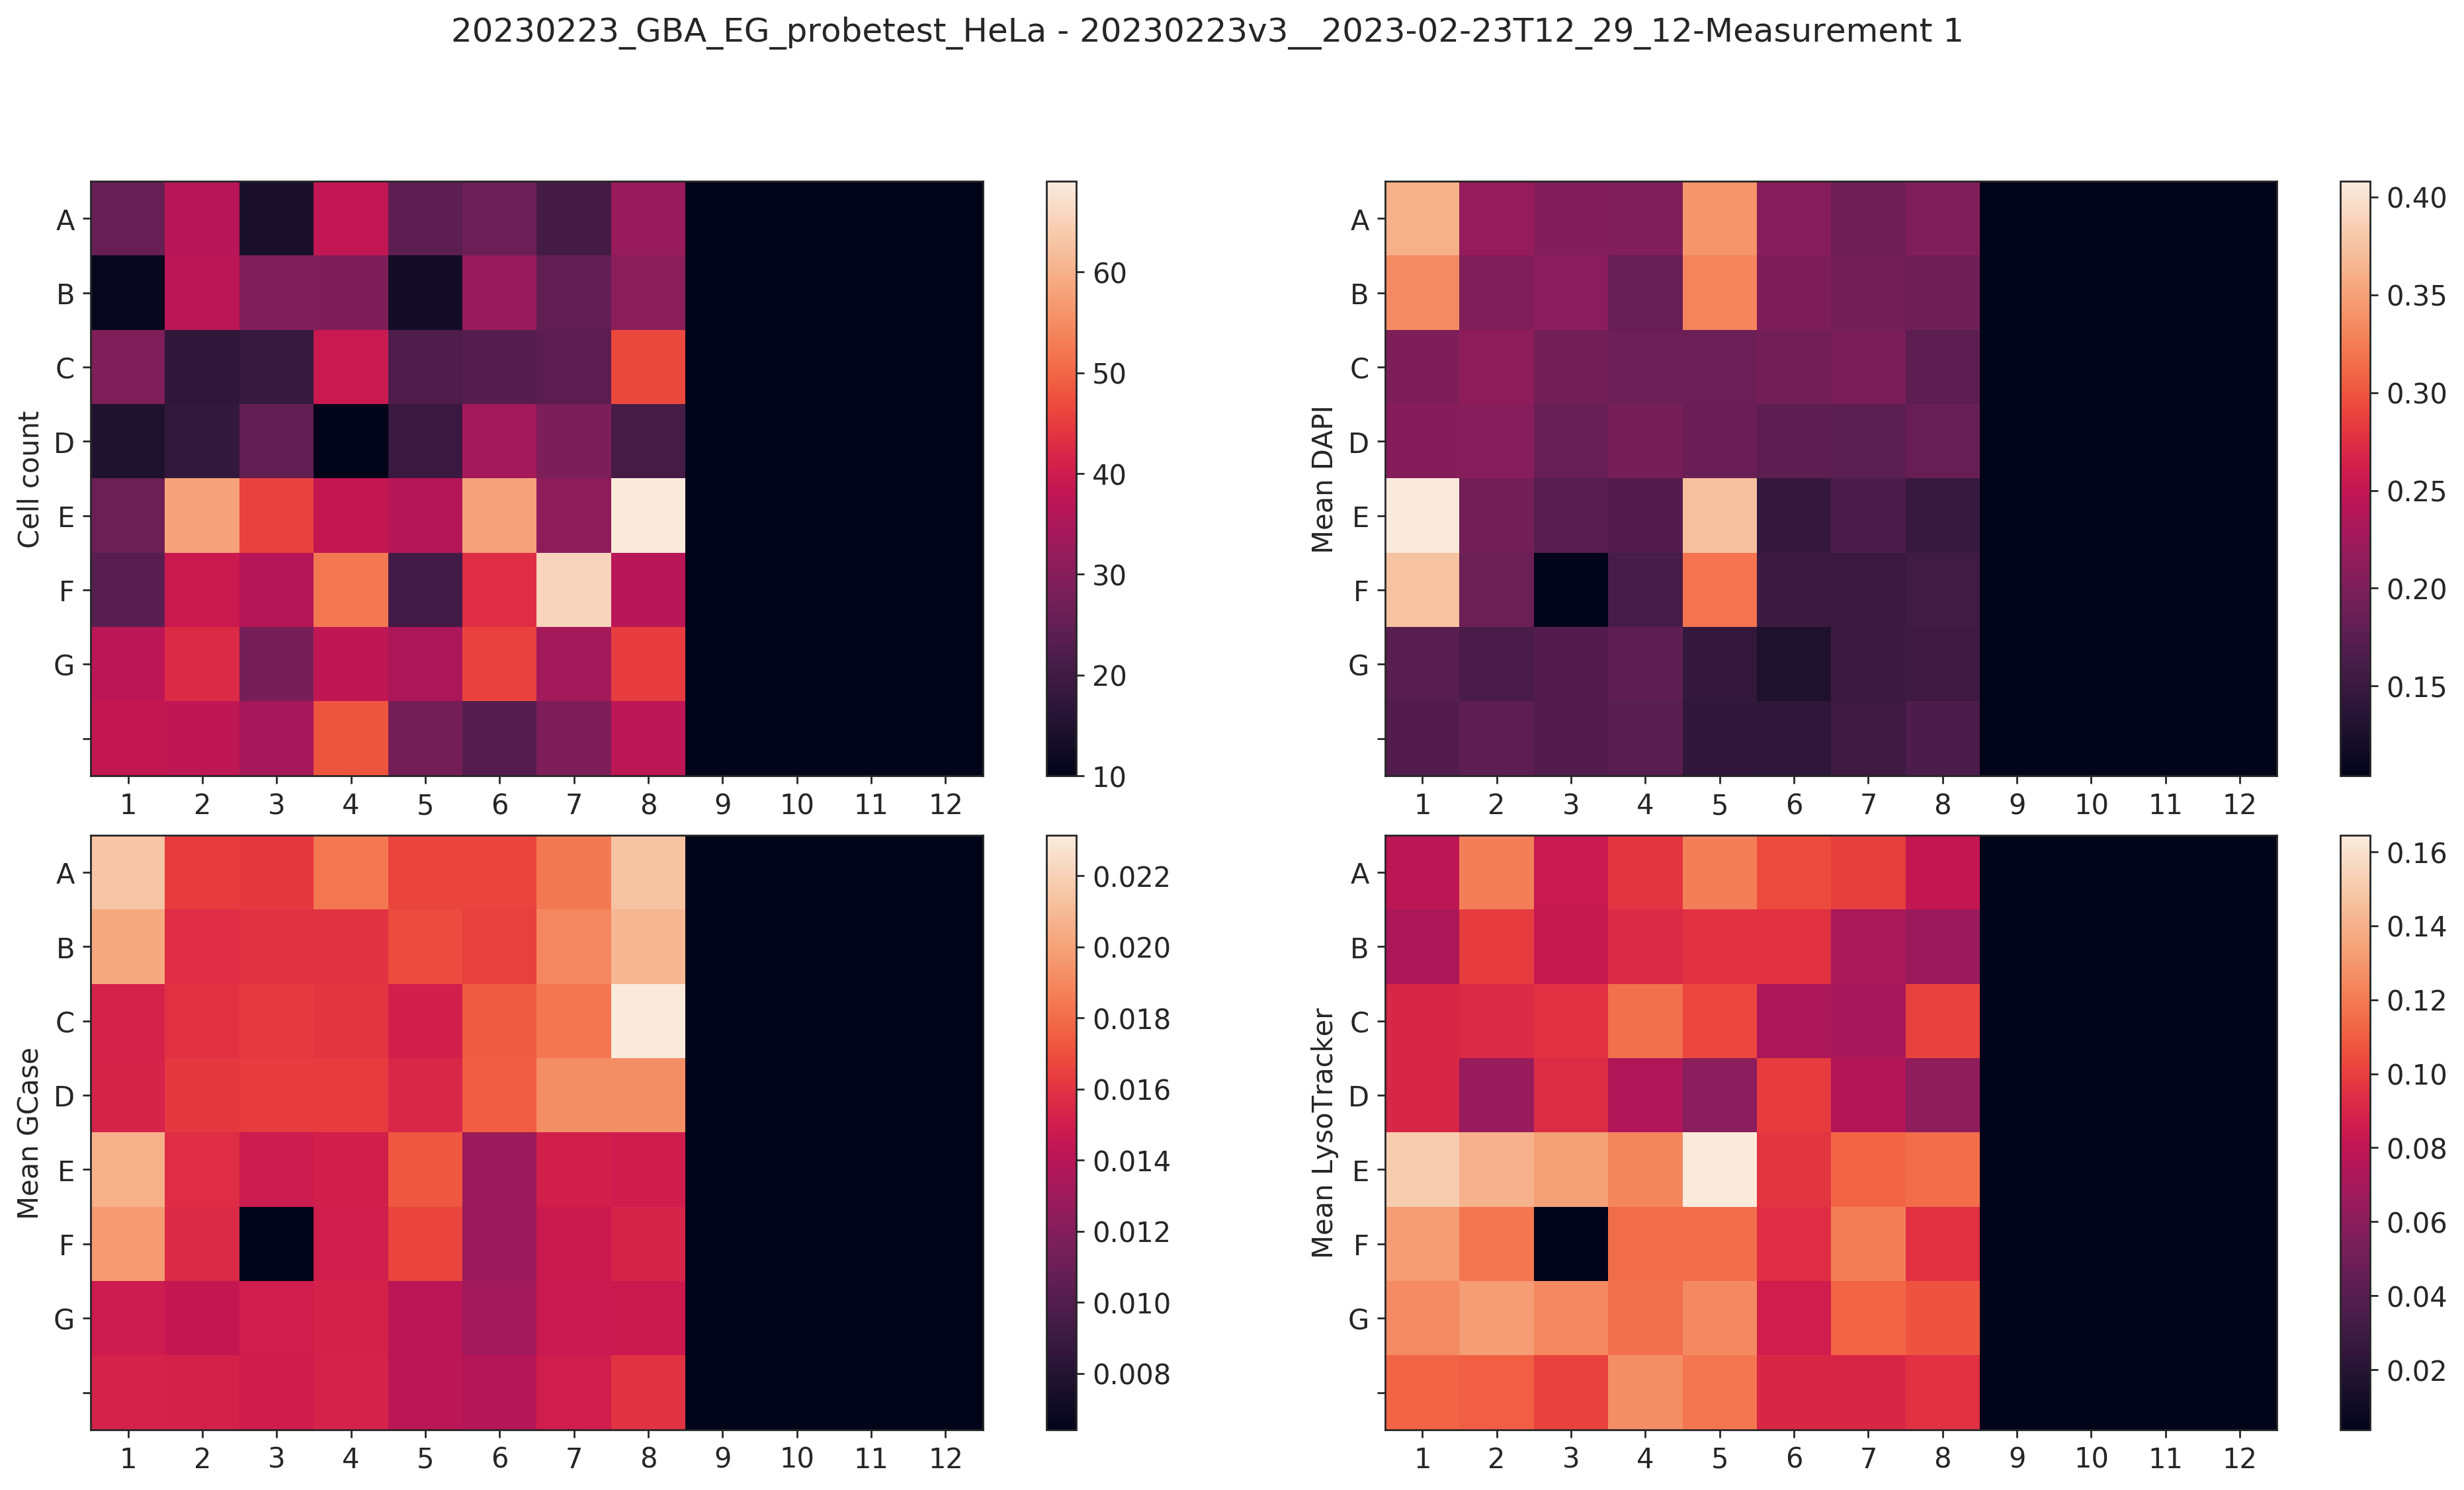

In [2]:
data_dir = Path('/lab/processed-data/20230223_GBA_EG_probetest_HeLa/20230223v3__2023-02-23T12_29_12-Measurement 1/')
platemap = pd.read_csv(data_dir / 'platemap.csv')
data = pd.read_csv(data_dir / '2023-03-08_GBA_analysis' / '2023-03-08_GBA_analysis_Image.csv')
filename = 'FileName_DAPI'

# Set filename and well position
data['well_position'] = data[filename].apply(
    lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
)
# Set filename and well position
plate = np.zeros([8, 12])
data['well_position'] = data[filename].apply(
    lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
)
data['row'] = data[filename].apply(
    lambda fname : int(fname[1:3])
)
data['col'] = data[filename].apply(
    lambda fname : int(fname[4:6])
)
data = data.merge(platemap, on='well_position')
data = data.groupby(['well_position', 'row', 'col', 'crispr']).mean()
# data = data.groupby(['FileName_NeuO_pre_illum', 'crispr', 'treatment', 'concentration']).mean()
data = data.reset_index()

measurements = [
    'Count_cytoplasm_outlines',
    'Mean_cytoplasm_outlines_Intensity_MeanIntensity_DAPI_corrected',
    'Mean_cytoplasm_outlines_Intensity_MeanIntensity_GCase_corrected',
    'Mean_cytoplasm_outlines_Intensity_MeanIntensity_LysoTracker_corrected'
]

sns.set_style('ticks')
fig, axs = plt.subplots(2,2)

for i_m, m in enumerate(measurements):

    axs_row = floor(i_m/2)
    axs_col = i_m % 2

    plate[data['row']-1, data['col']-1] = data[m]
    vmin = plate[plate != plate.min()].min()
    im = axs[axs_row, axs_col].imshow(plate, vmin=vmin)
    axs[axs_row, axs_col].set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
    axs[axs_row, axs_col].set_xticklabels([1,2,3,4,5,6,7,8,9,10,11,12])
    axs[axs_row, axs_col].set_yticks([0,1,2,3,4,5,6,7])
    axs[axs_row, axs_col].set_yticklabels(['A','B','C','D','E','F','G'])
    plt.colorbar(im, ax=axs[axs_row, axs_col])
    # plt.title(data_dir.parents[0].name + ' - ' + data_dir.name)

    # axs[axs_row, axs_col].tick_params(axis='x', rotation=25)
    axs[axs_row, axs_col].set_ylabel(m.split('_')[0] + ' ' + m.split('_')[-2])
    # axs[axs_row, axs_col].xaxis.grid(True)
    # axs[axs_row, axs_col].legend('')

axs[0, 0].set_ylabel('Cell count')
plt.suptitle(data_dir.parents[0].name + ' - ' + data_dir.name)
plt.subplots_adjust(wspace=0.02, hspace=0.1)

In [ ]:
data_dir = Path('/lab/raw-data/20230223_GBA_EG_probetest_HeLa/20230223v3__2023-02-23T12_29_12-Measurement 1/')
save_dir = Path('/lab/processed-data/20230223_GBA_EG_probetest_HeLa/20230223v3__2023-02-23T12_29_12-Measurement 1/')
pm = pd.read_csv(save_dir / '2023-03-08_GBA_analysis' / '2023-03-08_GBA_analysis_Image.csv')
pm['filename'] = pm['FileName_LysoTracker_corrected']
img_dir = 'Images'
# img_dir = '2023-03-08_GBA_analysis/soma_outlines'
img_stack = np.zeros((pm.shape[0], 1080, 1080))
img_stack = img_stack.astype('uint16')
for i_file, file in enumerate(pm['filename']):
    # tif = skimage.io.imread(save_dir / img_dir / (file))
    tif = skimage.io.imread(data_dir / img_dir / (file))
    img_stack[i_file, :, :] = tif
# img_stack 
# tifffile.imwrite(save_dir / '2023-03-08_GBA_analysis' / ('soma_outlines.tiff'), img_stack, metadata={'axes': 'ZYX'}, imagej=True, compression='lzw', dtype='uint16')
tifffile.imwrite(save_dir / ('max_projections_LysoTracker.tiff'), img_stack, metadata={'axes': 'ZYX'}, imagej=True, compression='lzw', dtype='uint16')

In [ ]:
platemap.merge(data[measurements], on='well_position').to_csv(
    '/lab/processed-data/20230223_GBA_EG_probetest_HeLa/20230223v3__2023-02-23T12_29_12-Measurement 1/2023-03-08_GBA_analysis/20230223_GBA_EG_probetest_HeLa_analysis.csv'
)